# SIIM-ISIC Melanoma Classification SoSe24

Folgender Block lädt willkürliche Libraries, weil ich keine Ahnung habe was ich mache, aber dafür gibt es einen coolen Timer.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import datetime
import numpy as np
import pandas as pd # Einlesen von CSV Dateien
import warnings
from tqdm import tqdm # Ladebalken
from tqdm.contrib.concurrent import process_map
from concurrent.futures import ThreadPoolExecutor # Multiprocessing beschleunigt das Laden um etwa das 6 Fache
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt # Anzeigen von Bildern
import plotly.express as px # Interaktive Diagramme

from sklearn.model_selection import train_test_split # Aufteilen in Trainings- und Validierungssa#tze
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder # Kodierung der Labels

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers

warnings.filterwarnings('ignore')

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

2024-04-20 09:25:17.512811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 09:25:17.512943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 09:25:17.621384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'Fertiggestellt um 09:25:27 den 04/20/24'

# Visualisierung der absoluten Häufigkeit der Merkmalsausprägungen

In [2]:
# CSV-Datei lesen
data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')

# Merkmalsausprägungen und Verteilung extrahieren
sex_counts = data['sex'].value_counts()
age_counts = data['age_approx'].value_counts()
anatom_counts = data['anatom_site_general_challenge'].value_counts()
target_counts = data['target'].value_counts()

# Daten in DataFrame umwandeln und Spalten bennenen
sex_df = pd.DataFrame({'Abs. H.': sex_counts.values}, index=sex_counts.index)
age_df = pd.DataFrame({'Abs. H.': age_counts.values}, index=age_counts.index)
anatom_df = pd.DataFrame({'Abs. H.': anatom_counts.values}, index=anatom_counts.index)
target_df = pd.DataFrame({'Abs. H.': target_counts.values}, index=target_counts.index)

# Kuchendiagramme erstellen
fig_sex = px.pie(sex_df, names=sex_df.index, values='Abs. H.', title='Geschlecht', 
                  labels={'Abs. H. ': 'Anzahl '})
fig_age = px.pie(age_df, names=age_df.index, values='Abs. H.', title='Gesch. Alter', 
                 labels={'Abs. H. ': 'Anzahl '})
fig_anatom = px.pie(anatom_df, names=anatom_df.index, values='Abs. H.', title='Anatom. Stelle', 
                    labels={'Abs. H. ': 'Anzahl '})
fig_target = px.pie(target_df, names=target_df.index, values='Abs. H.', title='Target', 
                    labels={'Abs. H. ': 'Anzahl '})

# Diagramme anzeigen
fig_sex.show()
fig_age.show()
fig_anatom.show()
fig_target.show()

# Laden der Bilder und dazugehörigen CSV Dateien. 
Der folgende Block lädt Bilder und CSV Daten. Diese werden multiprocessed, um die Arbeitszeit zu vervierfachen i.e. anstelle der sonstigen >5min/1000 Bilder in <2m/1000 Bilder

In [3]:
path_data_train = '/kaggle/input/siim-isic-melanoma-classification/train.csv'
path_image_train = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'

# Funktion zum Laden von Bildern
def load_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    return np.array(image)

def load_data(csv_file, image_dir, max_images=None, target_size=(256, 256), num_workers=None):
    data = pd.read_csv(csv_file)
    if max_images is not None:
        data = data.head(max_images)

    # Auswählen der relevanten Spalten für Kodierung
    data_for_encoding = data[['sex', 'age_approx', 'anatom_site_general_challenge', 'target']]

    # Kodieren der kategorialen Variablen in numerische Werte
    label_encoders = {}
    for column in ['sex', 'age_approx', 'anatom_site_general_challenge', 'target']:
        label_encoders[column] = LabelEncoder()
        data_for_encoding[column] = label_encoders[column].fit_transform(data_for_encoding[column])

    # Extrahieren der Bildnamen
    image_names = data['image_name'].values

    images = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for image_name in image_names:
            image_path = os.path.join(image_dir, image_name + '.jpg')
            futures.append(executor.submit(load_image, image_path, target_size))

        for future in tqdm(futures, desc="Lade Bilder", total=len(futures)):
            images.append(future.result())

    labels = data_for_encoding.values

    return np.array(images), np.array(labels), image_names, label_encoders


# Anzahl der Prozesse oder Threads einstellen
num_workers = os.cpu_count() or 1

# Laden der Trainingsdaten mit kodierten Labels
train_images, train_labels, train_image_names, label_encoders = load_data(path_data_train, path_image_train, max_images=None)


# Aufteilen der Trainingsdaten in Trainings- und Validierungssätze
train_images, val_images, train_labels, val_labels, train_image_names, val_image_names = train_test_split(train_images, 
                                                                                                          train_labels, 
                                                                                                          train_image_names, 
                                                                                                          test_size=0.2, 
                                                                                                          random_state=42)


datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

Lade Bilder: 100%|██████████| 33126/33126 [47:34<00:00, 11.60it/s]  


'Fertiggestellt um 10:13:29 den 04/20/24'

# Anzeigen eines Melanombildes zur überprüfung, dass die Daten korrekt geladen wurden
Um die geladenen Bilder und Labels auf Synchronität zu prüfen, müssen manuell die Bildnamen, die Bilder

34 

Das Bild 'ISIC_4439054' ist ein Melanom.


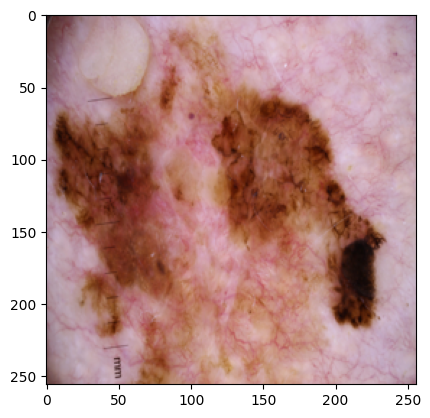

In [4]:
for i, label in enumerate(train_labels):
    if label[-1] == 1:
        print(i, '\n')
        print(f"Das Bild '{train_image_names[i]}' ist ein Melanom.")
        plt.figure()
        plt.imshow(train_images[i])
        plt.show()
        break # Nur 1. Wenn break auskommentiert wird, dann alle Melanome

# Model definieren

In [5]:
# Definieren des Modells
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Ausgabeschicht mit einem Neuron und Sigmoid-Aktivierungsfunktion
])

# Kompilieren des Modells
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binäre Kreuzentropie als Verlustfunktion für binäre Klassifikation
              metrics=['accuracy'])



datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

'Fertiggestellt um 10:15:56 den 04/20/24'

In [7]:
# Anpassen des Modells an die Trainingsdaten
history = model.fit(train_images, train_labels[:, -1], epochs=10, batch_size=16, validation_data=(val_images, val_labels[:, -1]))

Epoch 1/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.9816 - loss: 0.0893 - val_accuracy: 0.9820 - val_loss: 0.0853
Epoch 2/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.9831 - loss: 0.0835 - val_accuracy: 0.9820 - val_loss: 0.0906
Epoch 3/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - accuracy: 0.9832 - loss: 0.0983 - val_accuracy: 0.9820 - val_loss: 0.0856
Epoch 4/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.9818 - loss: 0.0885 - val_accuracy: 0.9820 - val_loss: 0.0845
Epoch 5/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - accuracy: 0.9832 - loss: 0.0857 - val_accuracy: 0.9820 - val_loss: 0.0895
Epoch 6/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.9842 - loss: 0.0827 - val_accuracy: 0.9820 - val_loss: 0.0996
Epoch 7/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.9830 - loss: 0.0874 - val_accuracy: 0.9820 - val_loss: 0.0891
Epoch 8/10
1657/1657 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.9809 -

In [8]:
model.save("/kaggle/working/model1.h5")
datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

'Fertiggestellt um 10:56:09 den 04/20/24'

# Visualisierung der Ergebnisse

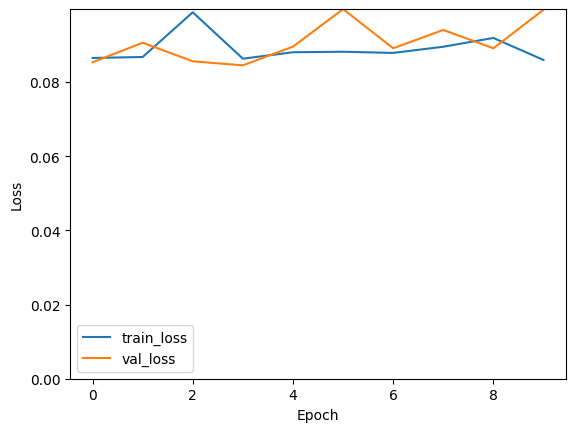

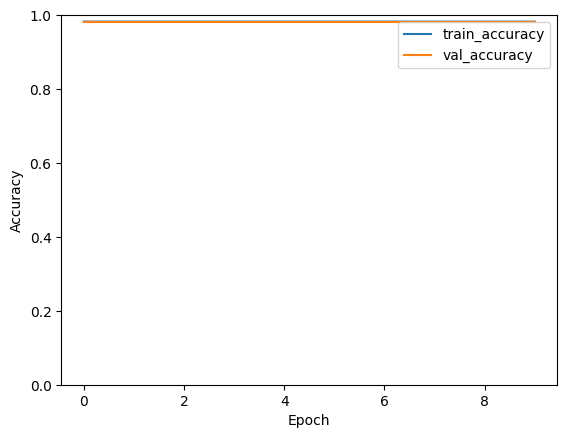

In [17]:
# Visualisierung der Trainings- und Validierungsverluste
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Setze die y-Achsenbegrenzung von 0 bis zum maximalen Verlustwert
plt.legend()
plt.show()

# Visualisierung der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Setze die y-Achsenbegrenzung von 0 bis 1 für die Genauigkeit
plt.legend()
plt.show()

In [15]:
import gc
gc.collect()

828

# Testbilder

In [16]:
# Pfade für Testdaten und CSV-Datei definieren
path_data_test = '/kaggle/input/siim-isic-melanoma-classification/test.csv'
path_image_test = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test'

def load_test_data(csv_file, image_dir, max_images=None, target_size=(256, 256), num_workers=None):
    data = pd.read_csv(csv_file)
    if max_images is not None:
        data = data.head(max_images)

    # Kodieren der kategorialen Variablen in numerische Werte mit den vorher trainierten Label Encodern
    for column in ['sex', 'age_approx', 'anatom_site_general_challenge']:
        if column in label_encoders:
            data[column] = label_encoders[column].transform(data[column])

    # Extrahieren der Bildnamen
    image_names = data['image_name'].values

    return image_names, data

def load_test_images(image_names, image_dir, target_size=(256, 256), num_workers=None):
    images = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for image_name in image_names:
            image_path = os.path.join(image_dir, image_name + '.jpg')
            futures.append(executor.submit(load_image, image_path, target_size))

        for future in tqdm(futures, desc="Lade Testbilder", total=len(futures)):
            images.append(future.result())

    return np.array(images)


# Laden der Testdaten
test_image_names, test_data = load_test_data(path_data_test, path_image_test)

# Laden der Testbilder
test_images = load_test_images(test_image_names, path_image_test)

# Modell laden
from keras.models import load_model
model_load = load_model('/kaggle/input/model-1/tensorflow1/model1/1/model1.h5')

# Vorhersagen für Testdaten machen
predictions = model_load.predict(test_images)

# Schwellenwert für die Klassifizierung festlegen
threshold = 0.5

# Vorhersagen in binäre Werte umwandeln
binary_predictions = (predictions > threshold).astype(int)

# Ergebnisse in eine DataFrame speichern, einschließlich der Bildnamen
results_df = pd.DataFrame({'image_name': test_image_names, 'target': binary_predictions.flatten()})

# Ergebnisse in eine CSV-Datei speichern
results_df.to_csv('/kaggle/working/submission.csv', index=False)


Lade Testbilder: 100%|██████████| 10982/10982 [12:45<00:00, 14.34it/s]


344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step


In [ ]:

def display_test_images(test_images, test_image_names, num_images=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(test_images[i])
        plt.title(test_image_names[i])
        plt.axis('off')
    plt.show()

# Anzahl der Testbilder, die angezeigt werden sollen
num_display_images = 5

# Testbilder und Namen anzeigen
display_test_images(test_images, test_image_names, num_display_images)